# FitzHugh--Nagumo model

The FitzHugh–Nagumo model represents a model for the
study of excitable media. The propagation of the transmembrane potential $u$ is modeled by a diffusion equation with a cubic nonlinear reaction term, whereas the recovery of the slow variable $v$ is represented by a single ordinary differential equation. The system of equations reads as follows:

\begin{align}
\frac{\partial u}{\partial t} &= D \Delta u + u(1-u)(u-a) -v + S  \qquad \text{ for } x \in \Omega \text{ and for } t \in [0, T], \\
\frac{\partial v}{\partial t} &= \epsilon (\beta u - \gamma v) \qquad x \in \Omega \text{ and for } t \in [0, T]
\end{align}

$\Omega$ denotes the spatial domain and $t$ is time. We consider the following choice of model parameters: $K_u = 0.001$, $a = 0.1$, $\epsilon = 0.01$,
$\beta = 0.5$, $\gamma = 1.0.$ These parameters generate stable patterns in  the system in the form of re--entrant spiral waves.

$S$ is a stimulus that we use to perturb the system.

 # Semi-discrete problem and weak formulation

At each time step we have the semidiscretized system to solve:

\begin{align}
\frac{u^n - u^{n-1}}{\Delta t} &= D \Delta u^n + u^n(1-u^n)(u^n-a) - v^n + S  \qquad \text{ for } x \in \Omega \text{ and for } t \in [0, T], \\
\frac{v^n - v^{n-1}}{\Delta t} &= \epsilon (\beta u^n - \gamma v^n) \qquad x \in \Omega \text{ and for } t \in [0, T]
\end{align}

The weak formulation reads as follows:

Find $u^n$, $v^n$ s.t. 

\begin{align}
\langle \frac{u^n - u^{n-1}}{\Delta t}, \psi_u \rangle &= - D \langle \nabla u^n, \nabla \psi_u \rangle + \langle u^n(1-u^n)(u^n-a), \psi_u \rangle - \langle v^n, \psi_u \rangle + \langle S, \psi_u \rangle \qquad \text{ for } x \in \Omega \text{ and for } t \in [0, T], \\
\langle \frac{v^n - v^{n-1}}{\Delta t}, \psi_v\rangle &= \epsilon (\beta \langle u^n, \psi_v \rangle - \langle \gamma v^n, \psi_v \rangle ) \qquad x \in \Omega \text{ and for } t \in [0, T]  \text{ and for all} \quad \psi_u, \psi_v
\end{align}

## FEniCS implementation

First, we define our domain and finite elements. We have a system of two equations, therefore we will use a Mixed Function Space where the first component is $u$ and the second is $v$.

In [1]:
from dolfin import *
%matplotlib inline
import pylab

# Define the mesh
N = 32
mesh = RectangleMesh(Point(0, 0), Point(2.5, 2.5), N, N)

# Define the mixed finite elements
Ue = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
Us = FunctionSpace(mesh, Ue)

element = MixedElement([Ue, Ue])
ME = FunctionSpace(mesh, element)


# Lower the log level to get more verbose output
set_log_level(40)

Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified


We need to define our stimulus $S$ and boundary conditions: 

In [2]:
def BC_U_and_stim(t):
    ## returns tuple of BCs to apply (to V) and stimulus term at time t
    ## What happens when you play with this parameters?
    start_stim_end_time = 6
    stimstarttime = 150
    stimduration = 6.
    stimamp = 0.8
    
    if t < start_stim_end_time:
        # set a Dirichlet boundary condition of u=1 at left edge of the domain, but no stimulus term S
        subdomain = CompiledSubDomain("near(x[0], 0) && on_boundary")
        return [DirichletBC(ME.sub(0), Constant(1), subdomain)], Constant(0)
    
    elif t > stimstarttime and t < stimstarttime + stimduration:
        # have no Dirichlet boundary conditions, but a stimulus in the bottom left quarter of the domain
        class Stimulus(UserExpression):
            def eval(self, value, x):
                if x[0] < 1.25 and x[1] < 1.25:
                    value[0] = stimamp
                else:
                    value[0] = 0

            def value_shape(self):
                return ()
        return [], Stimulus(degree=0)

    else:
        # no stimulus and no Dirichlet boundrary conditions
        return [], Constant(0)


For each time step we need to solve a linear system. We define parameters, trial and test functions, and weak formulation. In FEniCS it is possible to obtain the Jacobian of the nonlinear equations automatically:

In [3]:
def solve_single_timestep(Up, t, dt, theta=1):
    """
    Solve for a single time step

    Args:
        Up: Solution from previous tiem step
        t: Current simulation time
        dt: Size of time step
        theta: Choose discretization method (1=implicit Euler, 0.5=Crank-Nicholson, 0=Explicit Euler)
    """
    u_p, v_p = Up.sub(0), Up.sub(1)
    U = Function(ME)
    dU = TrialFunction(ME)
    psiU = TestFunction(ME)

    u, v = split(U)
    psiu, psiv = split(psiU)


    a = Constant(0.1)
    eps = Constant(0.01)
    beta = Constant(0.5)
    gamma = Constant(1)
    D = Constant(1E-4)
    dtc = Constant(dt)
    
    bcs, stim = BC_U_and_stim(t)
 
    def RHS_E1(v, w):
        return - D*inner(grad(u), grad(psiu)) + psiu *u*(1-u)*(u-a)  - w*psiu  + stim*psiu
    def RHS_E2(v, w):
        return eps*(beta*v - gamma*w)*psiv
        
    F1 = (u - u_p)/dtc * psiu * dx - (theta * RHS_E1(u, v_p) + (1-theta) * RHS_E1(u_p, v_p)) * dx
    F2 = (v - v_p)/dtc * psiv * dx - (theta * RHS_E2(u, v) + (1-theta) * RHS_E2(u_p, v_p)) * dx

    F = F1 + F2
    
    # Automatic differentiation! Isn't it cool?
    J = derivative(F, U, dU)
    
    # Define non linear variational problem
    problem = NonlinearVariationalProblem(F, U, bcs, J)
    
    # Assign initial guess to Newton solver
    # Try to remove this, what happens?
    assign(U.sub(0), u_p)
    assign(U.sub(1), v_p)

    # Newton solver
    solver = NonlinearVariationalSolver(problem)
    niter, _ = solver.solve()

    return niter, U


Once we defined the weak formulation and the nonlinear solver we can solve our equations for $t \leq T$:

In [6]:
import tqdm.notebook
# initial conditions
U = Function(ME)

# run solver

# optional saving to file
# fv = XDMFFile("output/u.xdmf")
# fw = XDMFFile("output/v.xdmf")

t = 0
dt = 4.
T = 500

U_sol = {}
n = 0
progress_bar_solver = tqdm.notebook.tqdm(int(T/dt), desc="Solving time dependent problem")
while t <= T:
    progress_bar_solver.update(1)

    t += dt
    n += 1
    niter, U = solve_single_timestep(U, t, dt)
    U_sol[n] = (t, U.copy())
    progress_bar_solver.set_description(f"t={t:4.2f}, number of Newton iterations={niter:2.0f}")
    # save to file
    # u_p, v_p = U.split(deepcopy=True)
    # u_p.rename("u", "name")
    # v_p.rename("v", "name")
    # fv.write(u_p, t)
    # fw.write(v_p, t)
# fv.close()
# fw.close()
progress_bar_solver.close()


Solving time dependent problem: 0it [00:00, ?it/s]

Creating animation: 128it [01:44,  1.22it/s]                         


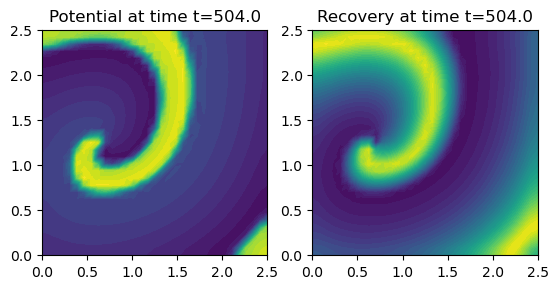

In [5]:
# from ipywidgets import interact, interactive, IntSlider

import itertools
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from functools import partial
fig = plt.figure()

N_frames = len(U_sol.keys()) 

def animate(i, progress_bar):
    progress_bar.update(1)
    t, U = U_sol[i+1]
    
    pylab.subplot(1, 2, 1)
    c1 = plot(U.sub(0)).collections
    plt.title(f"Potential at time t={t:0>4}")
    
    pylab.subplot(1, 2, 2)
    c2 = plot(U.sub(1)).collections
    plt.title(f"Recovery at time t={t:0>4}")
    
    return itertools.chain(c1, c2)

progress_bar = tqdm.notebook.tqdm(total=N_frames, desc="Creating animation")
anim = animation.FuncAnimation(fig, partial(animate, progress_bar=progress_bar),
                               frames=len(U_sol.keys()), interval=100, blit=True)


# cool animation
HTML(anim.to_jshtml())
progress_bar.close()


# slidable movie
# slider = IntSlider(min=min(U_sol.keys())-1, max=max(U_sol.keys())-1,continuous_update=False)
# slider.layout.width = "80%"
# interact(animate,i=slider)